# Get Me Outta Here!
**Anne Senay**
<br>
E-mail: u1154808@utah.edu
<br>
UID: u1154808

**Liz Maynard**
<br>
E-mail: liz.r.maynard@gmail.com
<br>
UID: u1194394
<br>

Link for video: [Get me Outta Here!](https://www.youtube.com/watch?v=7YhTXPQWCFQ&feature=youtu.be)

## Background and Motivation

In the last few decades, the world has become increasingly smaller. Our world has literally and virtually opened up through the advances in technology. Learning about foreign lands, cultures, and customs, including photos and maps, has become easily accessible. Doing business with others on the other side of the globe has become a norm. Families are no longer tethered to a piece of land and are free to explore opportunity wherever the wind blows them. 

Travel is the way we bridge the gap in many of these instances. We can visit family no matter where they live. We can work or study remotely and go into the office only when necessary. We can satisfy any and all curiosity about different countries and cultures. All we have to do is jump on a plane.

But traveling on a plane can also be a hassle. Many times it can be disrupted by weather, air traffic, or other unpredictable forces. And if we really want to go somewhere exciting (e.g. an international flight), it usually involves a connection through a large, busy airport. In this analysis, we will be looking at flights from some of the largest, busiest airports in the United States (New York City) to see if we can predict some of the uncertainty with air travel.

<img src="plane.jpg" alt="plane" width="600"/>

## Project Objectives

Questions we would like to address in this analysis:
1. Which airport has the most routes?
2. Which New York City airport is the busiest?
3. Which airline has the most flights? Most delays?
4. Are there certain times of year you should expect flight delays?
5. Can we predict a flight delay based on a few different factors?

## Ethical Considerations

This data has been released into the public domain. It does not contain any personal or sensitive information that we need to be concerned about. 

Those who would be most interested in this analysis would be travelers anticipating a flight to, from, or through one of the New York City airports. 

It could be detrimental to the reputation of an airline if the analysis shows that the airline experiences delays more regularly than other airlines. There could also be an airport that experiences more delays than average, which would be helpful to know in order to avoid connections through that airport.

## Data
 
The data for this project comes from a few different sources. We first used a web scraper to get a list of airports and their routes from [openflights.org](https://openflights.org/data.html).

The majority of the data, and what we used for our analysis comes from an R package called "nycflights13". This package contains datasets for historical flights from New York City airports in the year 2013, weather on those days, and airline information. Information about the R package and the data can be found [here](https://cran.r-project.org/web/packages/nycflights13/nycflights13.pdf).

## Data Processing

Includes web scraping, creating pandas data frames from csv files, merging datasets, removing NA values, creating masks for different visuals, and simplifying datasets for analysis.



In [1]:
# imports and setup 
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import statsmodels.formula.api as sm
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm, metrics


In [2]:
url = "https://openflights.org/data.html"

# access the website
with urllib.request.urlopen(url) as response:
    html = response.read()
    html = html.decode('utf-8')

# save the file
with open('openflights.html', 'w') as new_file:
    new_file.write(html)

soup = BeautifulSoup(html, 'html.parser')

#get links for data
files = []
for c in soup.find_all("p"):
    c_text = c.find("a")
    files.append(c_text)

In [3]:
#create dataframes from needed hrefs
airports = pd.read_csv(files[7].get("href"), header=None, names = ('AirportID','Name','City','Country','Airport Code','ICAO Code','Lat','Long','Altitude (ft)','Timecode','DST','Timezone','Type','Source'))
routes = pd.read_csv(files[30].get("href"), header=None, names=('Airline','ALcode','Source Airport','Source ID','Destination Airport','Destination ID','Codeshare','Stops','Equipment'))

#import csv files from R package
flights = pd.read_csv("flights.csv")
weather = pd.read_csv("weather.csv")
airlines = pd.read_csv("airlines.csv")

#remove NA values, including cancelled flights
flights.isnull().sum()
flights = flights.dropna()

To simplify the dataset for analysis, we combined a few smaller airlines with their larger, affiliated airline. We also removed flights from two smaller airlines that didn't have many flights from the NYC region in 2013 (Southwest and Mesa).


In [4]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00


In [5]:
weather.head()

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2012-12-31 17:00:00
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2012-12-31 18:00:00
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2012-12-31 19:00:00
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2012-12-31 20:00:00
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2012-12-31 21:00:00


In [6]:
airlines

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.
5,EV,ExpressJet Airlines Inc.
6,F9,Frontier Airlines Inc.
7,FL,AirTran Airways Corporation
8,HA,Hawaiian Airlines Inc.
9,MQ,Envoy Air


In [7]:
# Information about Airlines

# FL was acquired by WN in 2011, but functioned as FL until 2014; combined with WN
# MQ is a subsidiary to American Airlines; combined into one
# 9E is a subsidiary to Delta; combined into one
# OO is operated by contract with larger airlines; remove from dataset
# VX is now part of AS; combined into one
# YV is also mostly contracts with US and UA; removed from dataset

flights['carrier'] = flights['carrier'].replace('MQ', 'AA')
flights['carrier'] = flights['carrier'].replace('FL', 'WN')
flights['carrier'] = flights['carrier'].replace('9E', 'DL')
flights['carrier'] = flights['carrier'].replace('VX', 'AS')
flights = flights[(flights['carrier'] != 'OO') | (flights['carrier'] != 'YV')]

In [8]:
# merge the R package datasets into one
flights_combined = pd.merge(flights, airlines, on='carrier', how="left") 
flights_combined = pd.merge(flights_combined, weather, on=['origin','month','day','hour'], how="left")
flights_combined.head()

,year_x,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour_y
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,39.92,26.06,57.33,260.0,13.80936,15.891535,0.0,1011.9,10.0,2012-12-31 23:00:00


In [9]:
# check for rows that didn't have a match with the weather dataset
flights_combined.isnull().sum()
# remove NA values
flights_combined = flights_combined.dropna()

In [10]:
# now let's only include the columns that are of value for analysis
flights2 = flights_combined[['year_x', 'month', 'day', 'dep_delay', 'arr_delay', 'carrier', 'origin', 'dest', 'air_time', 
                             'distance', 'hour', 'name', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 
                             'precip', 'pressure', 'visib']]

In [11]:
flights2.describe()

,year_x,month,day,dep_delay,arr_delay,air_time,distance,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
count,285820.0,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000,285820.000000
mean,2013.0,6.543300,15.827881,10.884683,4.868106,150.696284,1049.393811,13.098636,55.379774,40.187024,59.165188,201.693199,10.591826,12.188862,0.001643,1017.922994,9.545739
std,0.0,3.416196,8.739845,37.425388,41.974451,93.890103,737.370300,4.711571,18.096432,19.409451,18.416281,110.116887,12.483045,14.365239,0.014343,7.451145,1.557110
min,2013.0,1.000000,1.000000,-43.000000,-79.000000,21.000000,80.000000,5.000000,10.940000,-9.940000,13.000000,0.000000,0.000000,0.000000,0.000000,983.800000,0.000000
25%,2013.0,4.000000,8.000000,-5.000000,-17.000000,82.000000,502.000000,9.000000,39.920000,24.980000,44.920000,120.000000,6.904680,7.945768,0.000000,1012.900000,10.000000
50%,2013.0,7.000000,16.000000,-2.000000,-6.000000,129.000000,888.000000,13.000000,55.040000,41.000000,58.080000,230.000000,10.357020,11.918651,0.000000,1017.600000,10.000000
75%,2013.0,10.000000,23.000000,9.000000,12.000000,192.000000,1391.000000,17.000000,69.980000,57.020000,73.300000,300.000000,13.809360,15.891535,0.000000,1023.000000,10.000000
max,2013.0,12.000000,31.000000,1301.000000,1272.000000,695.000000,4983.000000,23.000000,100.040000,78.080000,100.000000,360.000000,1048.360580,1206.432388,0.380000,1042.100000,10.000000


## Exploratory Analysis


#### Which airport has the most routes?

Two of the New York City airports (Newark and JFK) are in the top 20 throughout the world. The top 20 are in locations of a lot of business, tourism, or likely places for connections to less common destinations.

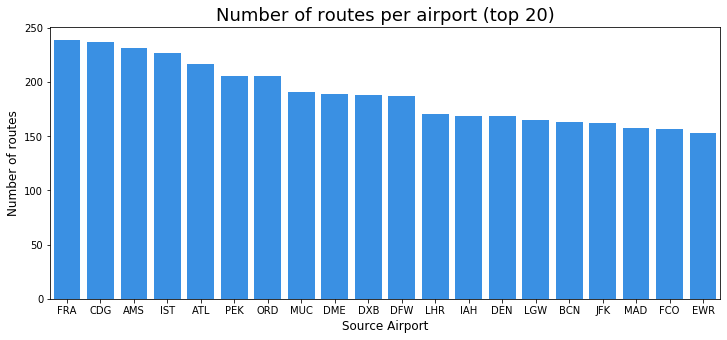

In [12]:
#which airport has the most routes?
all_most_routes = routes.groupby(['Source Airport','Destination Airport']).count().reset_index(drop=False).groupby('Source Airport').count().sort_values('Airline', ascending=False).reset_index(drop=False)
all_most_routes.head(20)
#2 of the NYC airports are in the top 20 busiest (most routes) in the world

fig = plt.figure(figsize=(12,5))

sns.barplot(x="Source Airport", y="Airline", data=all_most_routes.head(20), color="dodgerblue") 
plt.ylabel('Number of routes', fontsize=12)
plt.xlabel('Source Airport', fontsize=12)
plt.title('Number of routes per airport (top 20)', fontsize=18)
#plt.xticks(rotation='vertical')
plt.show()

In [13]:
all_most_routes[all_most_routes['Source Airport'].isin(['JFK','EWR','LGA'])]['Source Airport']

16     JFK
19     EWR
120    LGA
Name: Source Airport, dtype: object

In [14]:
top20 = list(all_most_routes['Source Airport'].unique()[0:20])
top20

colors = []
size = []
alpha = []
i = 0
while i < len(airports):
    if airports['Airport Code'][i] in top20:
        colors.append('lime')
        size.append(100)
        alpha.append(1)
    else:
        colors.append('red')
        size.append(5)
        alpha.append(.5)
    i += 1

C:\Users\annehurst\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


According to openflights.org there are 7698 around the world.


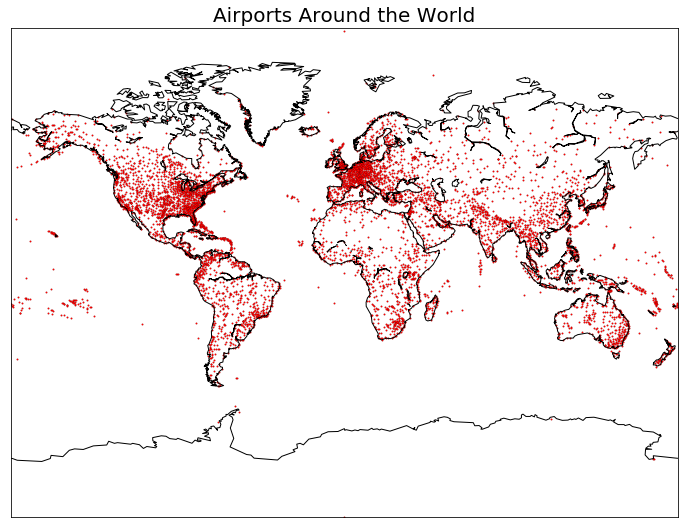

In [35]:
#https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
#https://www.youtube.com/watch?time_continue=43&v=XiZbrii49pI&feature=emb_logo

fig = plt.figure(figsize=(12,9))

m = Basemap(projection='mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
lat = airports["Lat"].tolist()
long = airports["Long"].tolist()

#m.scatter(long, lat, latlon=True, s=size, c=colors, edgecolor='k', linewidth=0.1)
m.scatter(long, lat, latlon=True, s=3, c='red', edgecolor='k', linewidth=0.1)
plt.title('Airports Around the World', fontsize=20)

print('According to openflights.org there are', str(len(airports)),'around the world.')

C:\Users\annehurst\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Top 20 Airports with the Most Routes')

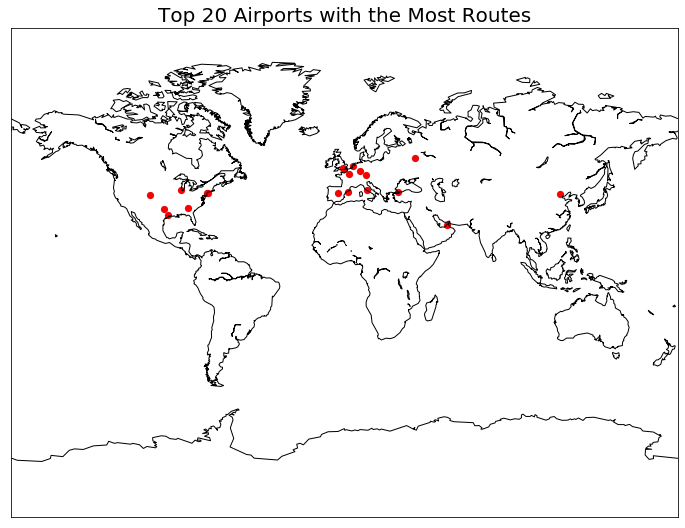

In [30]:
#Top 20 airports with the most routes

fig = plt.figure(figsize=(12,9))

m = Basemap(projection='mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
lat = airports[airports['Airport Code'].isin(top20)]["Lat"].tolist()
long = airports[airports['Airport Code'].isin(top20)]["Long"].tolist()

m.scatter(long, lat, latlon=True, s=50, c='red', edgecolor='k', linewidth=0.1)
plt.title('Top 20 Airports with the Most Routes', fontsize=20)


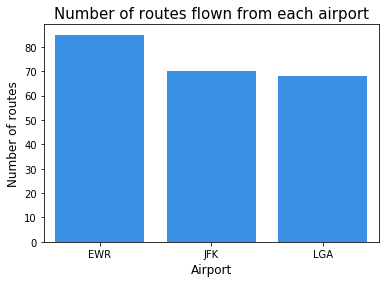

In [18]:
#which airport has the most routes
most_routes = flights.groupby(["origin","dest"]).count().reset_index(drop=False).groupby('origin').count().sort_values('year', ascending=False).reset_index(drop=False)

plt.figure(figsize=(12,5))
sns.barplot(x="origin", y="year", data=most_routes, color="dodgerblue")
plt.ylabel('Number of routes', fontsize=12)
plt.xlabel('Airport', fontsize=12)
plt.title('Number of routes flown from each airport', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

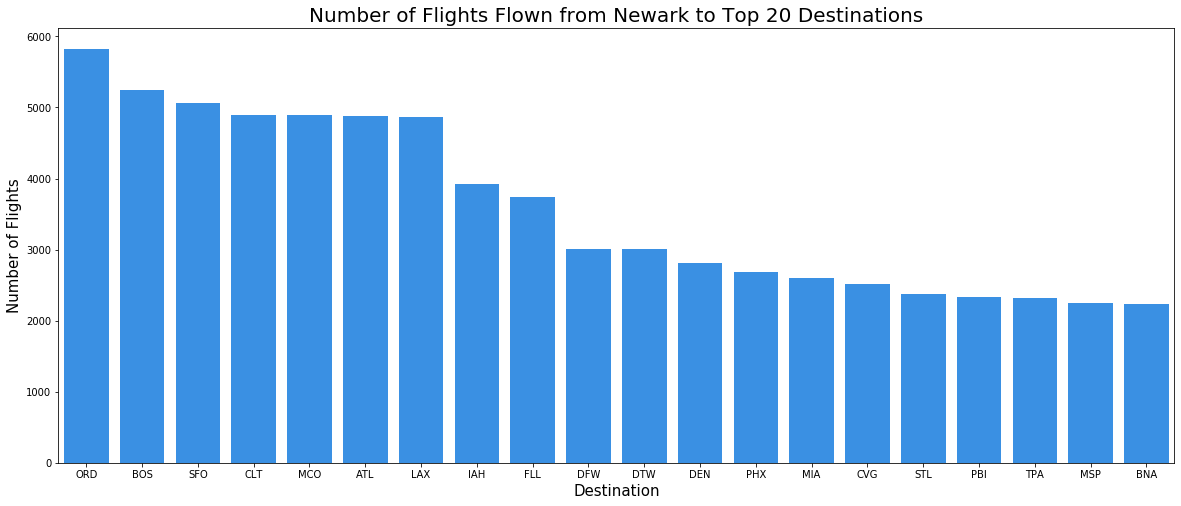

Newark flies 518 routes.


In [23]:
NWflights = flights[flights["origin"]=="EWR"]
NWflights2 = pd.DataFrame({"Origin": NWflights["origin"], "Dest": NWflights["dest"]})
NWroutes = NWflights2.groupby(['Dest']).count().sort_values('Origin', ascending=False).reset_index(drop=False)

plt.figure(figsize=(20,8))
sns.barplot(x="Dest", y="Origin", data=NWroutes.head(20), color="dodgerblue") 
plt.ylabel('Number of Flights', fontsize=15)
plt.xlabel('Destination', fontsize=15)
plt.title('Number of Flights Flown from Newark to Top 20 Destinations', fontsize=20)
plt.show()

print('Newark flies', len(str(NWroutes['Dest'].unique())),'routes.')

#### Which airline had the most outgoing flights? The most delays?

Delta had the most flights out of New York City, but ExpressJet Airlines experienced the most delays.

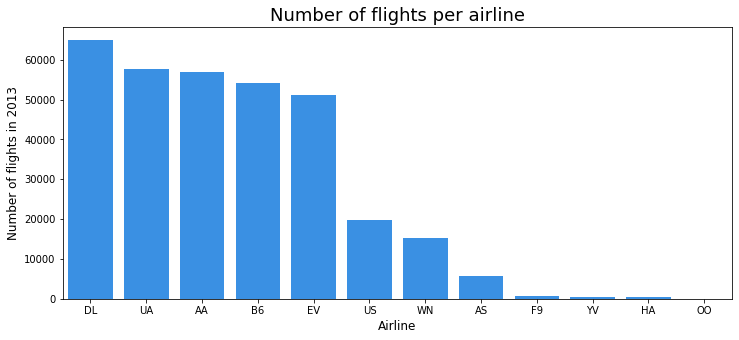

In [31]:
#which airline flew the most?
flight_count = flights.groupby("carrier").count().sort_values("year", ascending = False).reset_index(drop=False)

plt.figure(figsize=(12,5))
sns.barplot(x="carrier", y="year", data=flight_count, color="dodgerblue") 
plt.ylabel('Number of flights in 2013', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.title('Number of flights per airline', fontsize=18)
#plt.xticks(rotation='vertical')
plt.show()

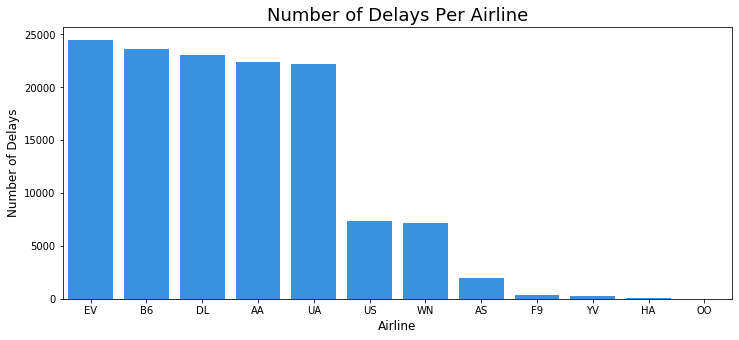

In [32]:
delays3 = flights[flights["arr_delay"]>0.0]
delays4 = pd.DataFrame({"Airline": delays3["carrier"], "Delays": delays3["arr_delay"]})

plt.figure(figsize=(12,5))
sns.countplot(x="Airline", data=delays4, color="dodgerblue", order=delays4['Airline'].value_counts().index) 
plt.ylabel('Number of Delays', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.title('Number of Delays Per Airline', fontsize=18)
plt.show()

#### Which NYC airport had the most outgoing flights? The most delays?

LaGuardia had the most flights in 2013, but Newark had the greater percentage of delays.

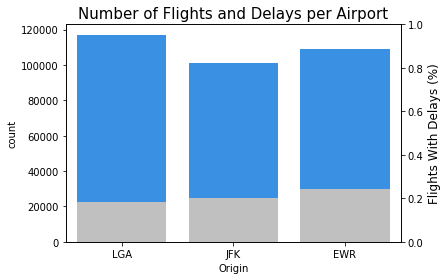

In [186]:
delaysap = flights[flights["arr_delay"]>15.0]
delaysap2 = pd.DataFrame({"Origin": delaysap["origin"], "Delays": delaysap["arr_delay"]})
totflights = pd.DataFrame({"Origin": flights["origin"], "Dest": flights["dest"]})

fig, ax = plt.subplots()
sns.countplot(x='Origin', data=totflights, color='dodgerblue', ax=ax)
ax2 = ax.twinx()
sns.countplot(x='Origin', data=delaysap2, color='silver', ax=ax)
plt.ylabel('Total Flights From Origin', fontsize=12)
plt.ylabel('Flights With Delays (%)', fontsize=12)
def change_width(ax2, new_value) :
    for patch in ax2.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax2, .35)
plt.title('Number of Flights and Delays per Airport', fontsize=15)
plt.show()

#### Are there certain times of year you should expect flight delays?

As shown below, December and the summer months had more flight delays. This makes sense since there are more travelers during these months either going on vacation or visiting family for the holidays.

As it turns out, there are also certain times of day you are more likely to experience a delay. The later afternoon, early evening hours are more likely to have a delay, likely due to higher traffic, both people and air traffic.

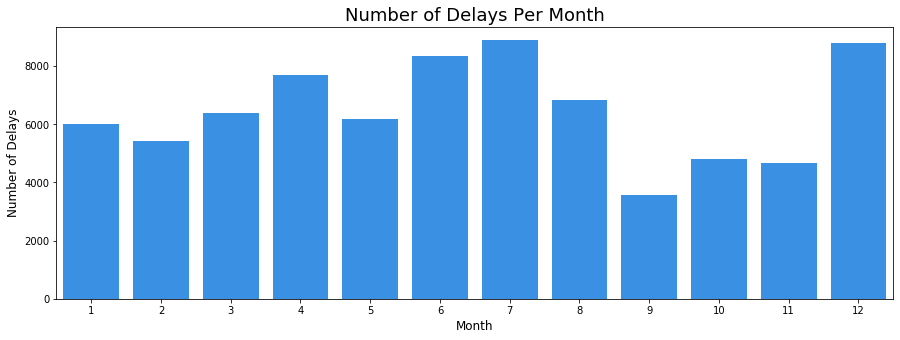

In [116]:
delaysmo = flights[flights["arr_delay"]>15.0]
delaysmo2 = pd.DataFrame({"Month": delaysmo["month"], "Delays": delaysmo["dep_delay"]})

plt.figure(figsize=(15,5))
sns.countplot(x="Month", data=delaysmo2, color="dodgerblue") 
plt.ylabel('Number of Delays', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Number of Delays Per Month', fontsize=18)
plt.show()

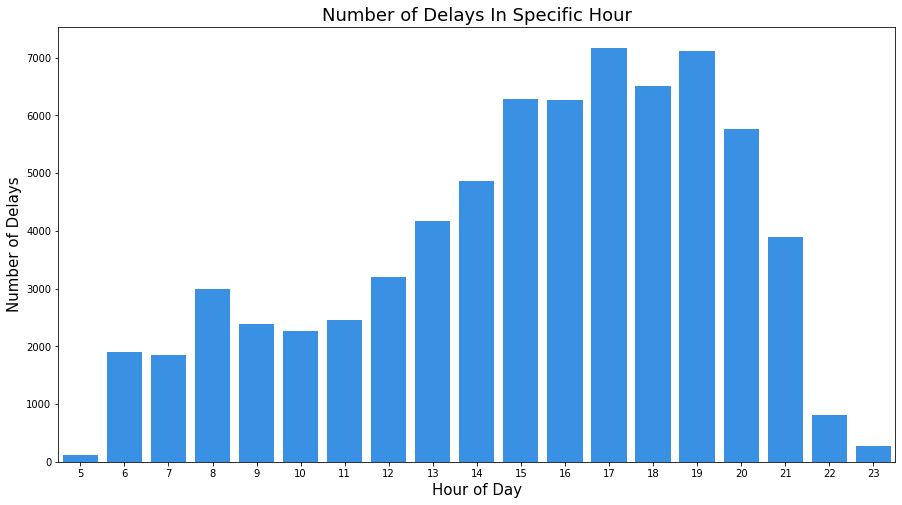

In [187]:
delaysho = flights[flights["dep_delay"]>15.0]
delaysho2 = pd.DataFrame({"Hour": delaysho["hour"], "Delays": delaysho["dep_delay"]})

plt.figure(figsize=(15,8))
sns.countplot(x="Hour", data=delaysho2, color="dodgerblue") 
plt.ylabel('Number of Delays', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.title('Number of Delays In Specific Hour', fontsize=18)
plt.show()

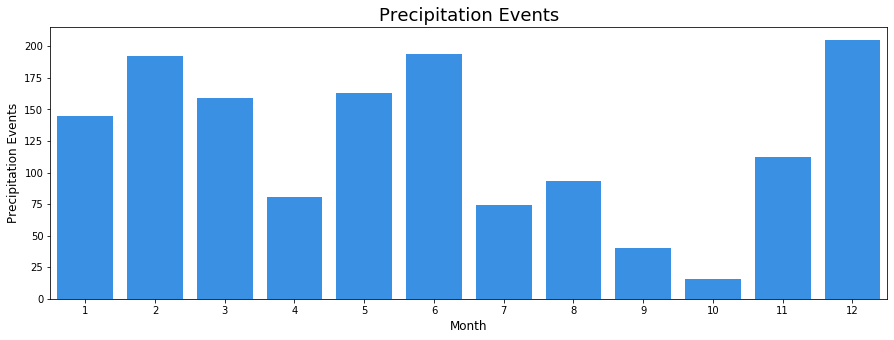

In [175]:
# We don't care so much about the amount of precipitation as we do how often it occurs since it could cause flights delays.
precip = weather[weather["precip"]>0.0]
monprecip = pd.DataFrame({"Month": precip["month"],"Precip": precip["precip"]})

plt.figure(figsize=(15,5))
sns.countplot(x="Month", data=monprecip, color="dodgerblue") 
plt.ylabel('Precipitation Events', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Precipitation Events', fontsize=18)
plt.show()

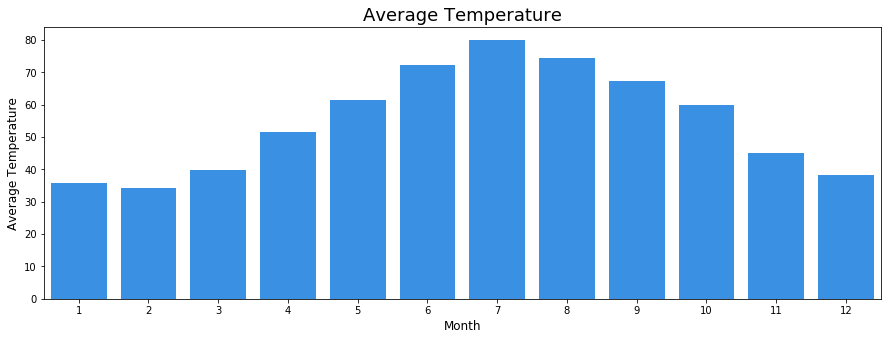

In [176]:
cnt = weather.groupby(['month']).count()['temp']
temp = weather.groupby(['month']).sum()['temp']
avg_temp = temp/cnt
avg_temp = avg_temp.to_frame().reset_index(drop=False)

plt.figure(figsize=(15,5))
sns.barplot(x="month", y="temp", data=avg_temp, color="dodgerblue") 
plt.ylabel('Average Temperature', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Average Temperature', fontsize=18)
plt.show()

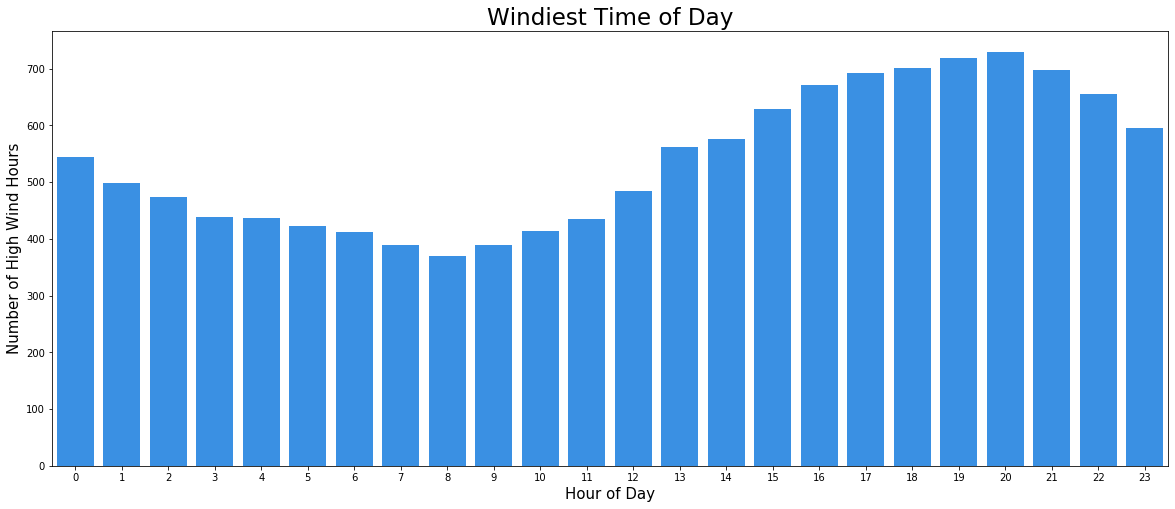

In [34]:
windmov = weather[weather["wind_speed"]>10.0]
windmov2 = pd.DataFrame({"Hour": windmov["hour"],"Speed": windmov["wind_speed"]})

plt.figure(figsize=(20,8))
sns.countplot(x="Hour", data=windmov2, color="dodgerblue") 
plt.ylabel('Number of High Wind Hours', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.title('Windiest Time of Day', fontsize=23)
plt.show()

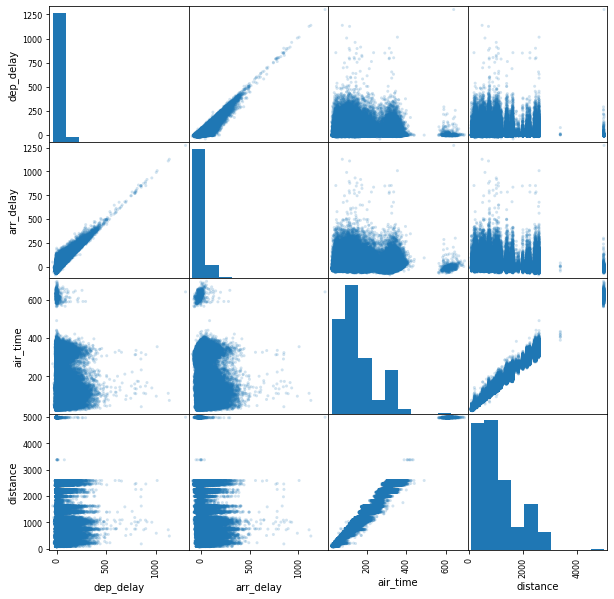

In [32]:
scatter_matrix(flights[['dep_delay', 'arr_delay', 'carrier', 'origin', 'dest', 'air_time', 'distance']], alpha = 0.2, figsize=(10, 10) )#, color=colors)
print()

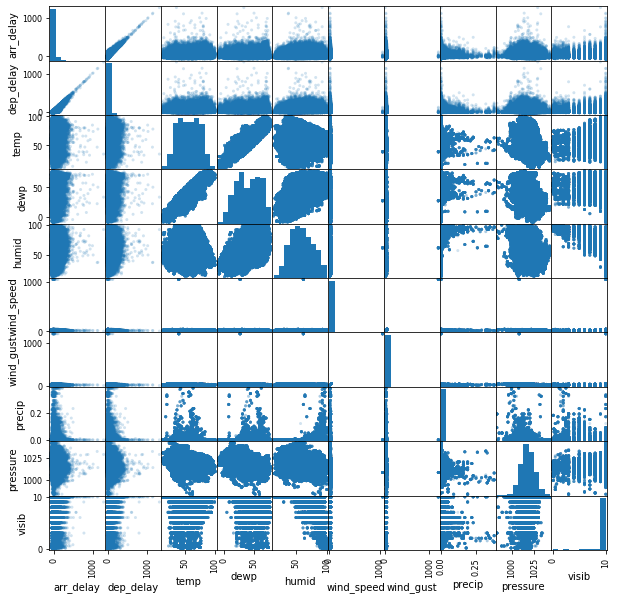

In [31]:
scatter_matrix(flights2[['arr_delay','dep_delay','temp','dewp','humid','wind_speed','wind_gust','precip','pressure','visib']], alpha = 0.2, figsize=(10, 10) )
print()

In [39]:
flights2[['month','arr_delay','dep_delay','temp','dewp','humid','wind_speed','wind_gust','precip','pressure','visib']].corr()

,month,arr_delay,dep_delay,temp,dewp,humid,wind_speed,wind_gust,precip,pressure,visib
month,1.000000,-0.026386,-0.026286,0.260810,0.262913,0.071475,-0.066134,-0.066134,-0.004659,0.089824,0.030267
arr_delay,-0.026386,1.000000,0.906992,0.063791,0.071709,0.039097,0.034555,0.034555,0.064021,-0.106479,-0.085413
dep_delay,-0.026286,0.906992,1.000000,0.094734,0.088180,0.016269,0.033040,0.033040,0.049829,-0.094275,-0.064748
temp,0.260810,0.063791,0.094734,1.000000,0.895868,0.071422,-0.068338,-0.068338,-0.024065,-0.237950,0.028214
dewp,0.262913,0.071709,0.088180,0.895868,1.000000,0.499541,-0.126660,-0.126660,0.048868,-0.271842,-0.147098
humid,0.071475,0.039097,0.016269,0.071422,0.499541,1.000000,-0.155723,-0.155723,0.187608,-0.162200,-0.457661
wind_speed,-0.066134,0.034555,0.033040,-0.068338,-0.126660,-0.155723,1.000000,1.000000,0.017673,-0.099118,0.046532
wind_gust,-0.066134,0.034555,0.033040,-0.068338,-0.126660,-0.155723,1.000000,1.000000,0.017673,-0.099118,0.046532
precip,-0.004659,0.064021,0.049829,-0.024065,0.048868,0.187608,0.017673,0.017673,1.000000,-0.108018,-0.336174
pressure,0.089824,-0.106479,-0.094275,-0.237950,-0.271842,-0.162200,-0.099118,-0.099118,-0.108018,1.000000,0.115629


### Preparing dataset for analysis

For the analysis, we created a few binary variables to represent the origin of the flight and the airlines. We then created a binary variable for arrival delay. We determined that a delay great than 15 minutes would be considered significant, especially for busy airports with a lot of air traffic.

In [34]:
# we can simplify the dataset by looking at only the airlines with more than 30k flights in 2013
flights3 = flights2[(flights2['carrier'] == 'UA') | (flights2['carrier'] == 'B6') | (flights2['carrier'] == 'EV') | 
                    (flights2['carrier'] == 'DL') | (flights2['carrier'] == 'AA') ] 

flights3['carrier'].unique()

array(['DL', 'B6', 'EV', 'AA', 'UA'], dtype=object)

In [35]:
flights_dummy = pd.get_dummies(flights3, columns=['origin', 'carrier'])
flights_dummy['arr_delay15'] = np.where(flights_dummy['arr_delay'] >= 15, 1, 0)
flights_dummy.head()

,year_x,month,day,dep_delay,arr_delay,dest,air_time,distance,hour,name,...,pressure,visib,origin_EWR,origin_JFK,origin_LGA,carrier_AA,carrier_B6,carrier_DL,carrier_EV,carrier_UA
4,2013,1,1,-6.0,-25.0,ATL,116.0,762,6,Delta Air Lines Inc.,...,1011.9,10.0,0,0,1,0,0,1,0,0
6,2013,1,1,-5.0,19.0,FLL,158.0,1065,6,JetBlue Airways,...,1012.0,10.0,1,0,0,0,1,0,0,0
7,2013,1,1,-3.0,-14.0,IAD,53.0,229,6,ExpressJet Airlines Inc.,...,1011.9,10.0,0,0,1,0,0,0,1,0
8,2013,1,1,-3.0,-8.0,MCO,140.0,944,6,JetBlue Airways,...,1012.6,10.0,0,1,0,0,1,0,0,0
9,2013,1,1,-2.0,8.0,ORD,138.0,733,6,American Airlines Inc.,...,1011.9,10.0,0,0,1,1,0,0,0,0


## Analysis


### Linear Regression

We started our analysis with linear regression to attempt to predict how long an arrive would be delayed. While many different factors can contribute to the delay of a flight, as shown below, the best predictor is, unsurprisingly, the departure delay. 

From our larger model, none of the factors we included appear insignificant, but the R-squared value is also incredibly low. The only way we could increase the R-squared value was by including the departure delay variable, which alone gives an R-squared value of over 80%.

In [20]:
#Regression - larger model
flight_model = sm.ols(formula="arr_delay ~ hour + month + distance + air_time + visib + precip + wind_speed*precip + carrier_AA + carrier_B6 + carrier_DL + carrier_UA", data=flights_dummy).fit()
flight_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              arr_delay   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     1917.
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:27:44   Log-Likelihood:            -1.2738e+06
No. Observations:              248941   AIC:                         2.548e+06
Df Residuals:                  248928   BIC:                         2.548e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.1025      0.637      4.872      0.000       1.854       4.351
hour                  1.4399      0.017     83.310      0.000       1.406       1.474
month                -0.1009      0.024     -4.230      0.000      -0.148      -0.054
distance             -0.0835      0.001   -102.081      0.000      -0.085      -0.082
air_time              0.6440      0.006    100.508      0.000       0.631       0.657
visib                -2.0453      0.055    -37.058      0.000      -2.154      -1.937
precip              164.1706     13.605     12.067      0.000     137.505     190.836
wind_speed            0.0435      0.006      6.741      0.000       0.031       0.056
wind_speed:precip    -4.3840      0.892     -4.914      0.000      -6.133      -2.635
carrier_AA           -9.1479      0.270    -33.932      0.000      -9.676      -8.619
carrier_B6           -4.1569      0.275    -15.136      0.000      -4.695      -3.619
carrier_DL          -11.1327      0.263    -42.321      0.000     -11.648     -10.617
carrier_UA           -8.5558      0.291    -29.447      0.000      -9.125      -7.986
==============================================================================
Omnibus:                   218758.959   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13427095.213
Skew:                           3.978   Prob(JB):                         0.00
Kurtosis:                      38.088   Cond. No.                     2.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#Regression - only dep_delay
flight_model = sm.ols(formula="arr_delay ~ dep_delay", data=flights_dummy).fit()
flight_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              arr_delay   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 1.163e+06
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:27:48   Log-Likelihood:            -1.0688e+06
No. Observations:              248941   AIC:                         2.138e+06
Df Residuals:                  248939   BIC:                         2.138e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3982      0.037   -172.661      0.000      -6.471      -6.326
dep_delay      1.0195      0.001   1078.460      0.000       1.018       1.021
==============================================================================
Omnibus:                    58872.720   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           255029.006
Skew:                           1.104   Prob(JB):                         0.00
Kurtosis:                       7.440   Cond. No.                         40.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Logistic Regression

We also included a logistic regression model using the binary arrival delay column we created. We see similar results here that departure delay is still the best indicator.

In [34]:
#logit - larger model
flights_logit = sm.logit(formula="arr_delay15 ~ hour + temp + wind_speed + precip + carrier_AA + carrier_B6 + carrier_DL + carrier_EV + carrier_UA", data=flights_dummy).fit()
flights_logit.summary()

         Current function value: 0.517477
         Iterations: 35


C:\Users\annehurst\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            arr_delay15   No. Observations:               248941
Model:                          Logit   Df Residuals:                   248932
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                 0.04174
Time:                        10:25:00   Log-Likelihood:            -1.2882e+05
converged:                      False   LL-Null:                   -1.3443e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2180   2.68e+05  -8.29e-06      1.000   -5.25e+05    5.25e+05
hour           0.0898      0.001     81.850      0.000       0.088       0.092
temp           0.0030      0.000     10.865      0.000       0.002       0.004
wind_speed     0.0038      0.001      7.341      0.000       0.003       0.005
precip         9.9043      0.330     30.003      0.000       9.257      10.551
carrier_AA    -0.5166   2.68e+05  -1.93e-06      1.000   -5.25e+05    5.25e+05
carrier_B6    -0.3926   2.68e+05  -1.47e-06      1.000   -5.25e+05    5.25e+05
carrier_DL    -0.7232   2.68e+05   -2.7e-06      1.000   -5.25e+05    5.25e+05
carrier_EV    -0.0567   2.68e+05  -2.12e-07      1.000   -5.25e+05    5.25e+05
carrier_UA    -0.5289   2.68e+05  -1.98e-06      1.000   -5.25e+05    5.25e+05
==============================================================================
"""

In [22]:
#logit - larger model
flights_logit = sm.logit(formula="arr_delay15 ~ dep_delay", data=flights_dummy).fit()
flights_logit.summary()

Optimization terminated successfully.
         Current function value: 0.280858
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            arr_delay15   No. Observations:               248941
Model:                          Logit   Df Residuals:                   248939
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.4799
Time:                        16:34:38   Log-Likelihood:                -69917.
converged:                       True   LL-Null:                   -1.3443e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3208      0.008   -284.019      0.000      -2.337      -2.305
dep_delay      0.1082      0.001    209.999      0.000       0.107       0.109
==============================================================================
"""

### Classification

We used two different classification methods to predict flight delays, k-Nearest Neighbors and Support Vector Machines.

In [183]:
#simplify dataset; drop columns that will not be used in the classification model
# This does not departure delay. Run this code first for the dataset for each classification model.
flights4 = flights_dummy.drop(['year_x', 'day', 'dest', 'dep_delay', 'arr_delay', 'humid', 'dewp','visib', 'name', 'wind_dir', 'wind_gust', 'pressure'], axis=1)


In [ ]:
# Run this and then run the classification models again (including the last line that is currently commented out). The accuracy improves significantly.
flights_dep_delay = flights_dummy.drop(['year_x', 'day', 'dest', 'arr_delay', 'humid', 'dewp','visib', 'name', 'wind_dir', 'wind_gust', 'pressure'], axis=1)
#flights4 = flights_dep_delay

Because only 23% of the flights were delayed, each model was predicting with an accuracy of at least 70% no matter which model or variables we chose. 

In [86]:
delayed = len(flights4[flights4['arr_delay15'] == 1]) 
print("Percentage or delayed flights:", str(delayed / len(flights4)) )

Percentage or delayed flights: 0.2306128761433432


In order to address this, we created a smaller subset of data for the flights that were not delayed in order to balance the data more. We used this smaller dataset in the k-NN model. 

The SVM has its own way of addressing this issue. We added class_weight = 'balanced' to the model, which takes into account the disproportion of data.

In [87]:
flights_ontime = flights4[flights4['arr_delay15'] == 0].sample(delayed)
print(len(flights_ontime))
print(delayed)
print(len(flights_ontime) + delayed)

57409
57409
114818


In [88]:
flights4_kNN = flights_ontime.append(flights4[flights4['arr_delay15'] == 1])
print(len(flights4))

248941


We used a smaller subset of data to run each model for testing, and then the full dataset once the models were defined.

In [184]:
#use a subset of the data for computations
flights4_small = flights4_kNN.sample(frac = 1)

X = flights4_small.drop(['arr_delay15'], axis=1).to_numpy()
y = flights4_small['arr_delay15'].to_numpy()

#### K-Nearest Neighbors

In [185]:
#K nearest neighbors

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.8)

model = KNeighborsClassifier(n_neighbors = 25)
model.fit(XTrain, yTrain)

print('Confusion Matrix:')
y_pred = model.predict(XTest)
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Precision = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Recall = ', metrics.recall_score(y_true = yTest, y_pred = y_pred))
print('F-score = ', metrics.f1_score(y_true = yTest, y_pred = y_pred))

print('Jaccard similarity score', metrics.jaccard_score(y_true = yTest, y_pred = y_pred))

Confusion Matrix:
[[30478 15420]
 [18383 27574]]
Precision =  0.6319960807794894
Recall =  0.599995648105838
F-score =  0.6199817877258266
Jaccard similarity score 0.44925623604933446


In [181]:
#choose the best k

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.6)

# specify the model and settings
cnt = 1
n = 50
p_score = []
k_list = []
while cnt <= n:
    k = cnt
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(XTrain, yTrain)
    y_pred = model.predict(XTest)
    p = metrics.accuracy_score(y_true = yTest, y_pred = y_pred)
    p_score.append(p)
    k_list.append(k)
    cnt += 1


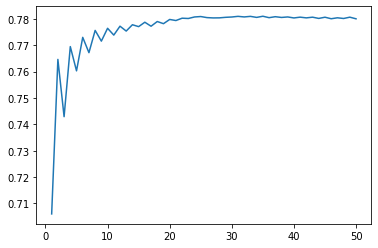

In [182]:
plt.plot(k_list, p_score)
#choose k=25

If 'dep_delay' is NOT included in the model, k needs to be much larger, about 25. If 'dep_delay' is included in the model, we can choose k to be about 12. Since the precision score is not impacted significantly choosing k=25, we left k=25 as the default for either model that is run.

#### Support Vector Machine

In [179]:
#use a subset of the data for SVM computations
flights4_small = flights4.sample(frac = 1)

X = flights4_small.drop(['arr_delay15'], axis=1).to_numpy()
y = flights4_small['arr_delay15'].to_numpy()

In [180]:
#SVM

XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.8)

model = svm.SVC(kernel='rbf', C=100, gamma='scale', class_weight = 'balanced')

model.fit(XTrain, yTrain)    
print(model)

print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Confusion Matrix:
[[120737  70795]
 [ 19468  37941]]
Accuracy =  0.6374120775605465


For the k-NN model, you have about a 50% chance of guessing randomly whether a flight would be delayed. The k-NN model shows the highest precision score achieved is about 63% at k=25. This is better than just randomly guessing, but not overwhelmingly so.

For either dataset, the SVM seems to be a little bit better at predicting a flight delay with about 64% accuracy. 

## Conclusion

The results of this analysis were not as exciting as we had hoped. While logically there seems to be many factors that could play into a flight arriving late, the biggest predictor is if it was delayed in the first place.

We played around with predicting a flight delay as well, but ran into the same conclusions. Airlines, and these airports, do remarkable well in getting their passengers to the correct locations on time, despite adverse weather conditions or high traffic times of day or year.

This would be an interesting study for other airports that are notorious for cancelled or delayed flights.